In [90]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import codecs
from pprint import pprint
from konlpy.tag import Twitter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

%matplotlib inline
print(tf.__version__)

2.0.0


In [91]:
#감정 분석에 필요한 konlpy 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install konlpy
!pip3 install Twitter

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease    
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease       
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease    
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Pack

In [121]:
# use only noun and adj.
def getNounAdjective(text):
    stems=[]
    twitter=Twitter()
    tagged=twitter.pos(text,stem=True)
    for i in range(0,len(tagged)):
        if (tagged[i][1]=='Noun' or tagged[i][1]=='Adjective'):
            stems.append(tagged[i][0])
    return ' '.join(stems)

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
# use only noun and adj.
def getNounAdjective(text):
    stems=[]
    tagged=twitter.pos(text,stem=True)
    for i in range(0,len(tagged)):
        if (tagged[i][1]=='Noun' or tagged[i][1]=='Adjective'):
            stems.append(tagged[i][0])
    return ' '.join(stems)

def read_data(filename):
    with open(filename,'r',encoding='utf8') as f:
        result=[line.split('\t') for line in f.read().splitlines()]
        result=result[1:]
    return result

In [95]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
#학습에 활용할 텍스트 파일 읽기
train_tmp = read_data('/gdrive/My Drive/Colab/ratings_train.txt')
test_tmp = read_data('/gdrive/My Drive/Colab/ratings_test.txt')

In [13]:
train_tmp[0]

['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0']

In [ ]:
def train_test_split():
    train_x=[]
    train_y=[]
    
    for i in range(len(train_tmp)):
        train_x.append(getNounAdjective(train_tmp[i][1]))
        train_y.append(int(train_tmp[i][2]))
        
    test_x=[]
    test_y=[]

    for i in range(len(test_tmp)):
        test_x.append(getNounAdjective(test_tmp[i][1]))
        test_y.append(int(test_tmp[i][2]))
        
    return (train_x, train_y), (test_x,test_y)

(x_train,y_train),(x_test,y_test)=train_test_split()

In [128]:
print(x_train[0:10])
print(y_train[0:10])

['더빙 진짜 짜증나다 목소리', '흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다', '무재 밓었 다그 래서 추천', '교도소 이야기 구먼 솔직하다 재미 없다 평점 조정', '몬페 의 익살스럽다 연기 영화 스파이더맨 커스틴 던스트 이쁘다', '막 걸음 마 세 초등학교 학년 생인 영화 반개 아깝다 움', '원작 긴장감 제대로', '별 반개 아깝다 욕 이응경 길용우 생활 년 정말 발 해도 그것 납치 감금 반복 반복 드라마 가족 없다 연기 사람 네', '액션 없다 재미 있다 몇 안되다 영화', '왜케 평점 낮다 꽤 볼 데 헐리우드 화려하다 있다']
[0, 1, 0, 0, 1, 0, 0, 0, 1, 1]


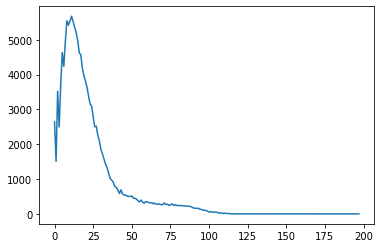

In [53]:
# see words(x), freq(y)
from collections import Counter
counter=dict(Counter([len(x) for x in x_train]))
lists = sorted(counter.items()) 
x,y = zip(*lists)
plt.plot(x,y)
plt.show()

In [ ]:
def tokenize():
    max_num_words=1000

    tokenizer=Tokenizer(num_words=max_num_words-1)
    tokenizer.fit_on_texts(x_train)

    x_train_token = tokenizer.texts_to_sequences(x_train)
    x_test_token=tokenizer.texts_to_sequences(x_test)

    one_word_idx=[i for i in range(len(x_train_token)) if len(x_train_token[i])<2] # remove one word sentence
    x_train_token=[text for i, text in enumerate(x_train_token) if i not in one_word_idx]
    y_train_token=[text for i, text in enumerate(y_train) if i not in one_word_idx]
    return x_train_token, y_train_token

x_train_token, y_train_token = tokenize()

In [ ]:
def padding_x():
    maxlen=40
    x_train_pad=pad_sequences(x_train_token, maxlen=maxlen, padding='post')
    x_test_pad=pad_sequences(x_test_token, maxlen=maxlen, padding='post')
    return x_train_pad, x_test_pad

def padding_y():
    y_train_pad=np.eye(2)[y_train_token]
    y_test_pad=np.eye(2)[y_test]
    return y_train_pad, y_test_pad

x_train_pad, x_test_pad = padding_x()
y_train_pad, y_test_pad = padding_y

In [ ]:
def show_wordmap():
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    return reverse_word_map

In [ ]:
def LSTM_modeling():
    num_classes = 2 # 0(positive), 1(negative)
    model=Sequential()
    model.add(layers.Embedding(input_dim=max_num_words,
                               output_dim=max_num_words,
                               input_length=maxlen,
                               embeddings_initializer=keras.initializers.Constant(one_hot)))
    model.add(tf.keras.layers.LSTM(units=128))
    model.add(layers.Dense(units=num_classes, activation=tf.nn.softmax))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [139]:
model = LSTM_modeling()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 1000)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               578048    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,578,306
Trainable params: 1,578,306
Non-trainable params: 0
_________________________________________________________________


In [142]:
batch_size=1000
model.fit(x_train_pad,y_train_pad, batch_size=batch_size, epochs=5,
         validation_data=(x_test_pad, y_test_pad))

Train on 126317 samples, validate on 50000 samples
Epoch 1/5
126317/126317 [==============================] - 315s 2ms/sample - loss: 0.4932 - accuracy: 0.7378 - val_loss: 0.4361 - val_accuracy: 0.7927
Epoch 2/5
126317/126317 [==============================] - 306s 2ms/sample - loss: 0.4017 - accuracy: 0.8160 - val_loss: 0.4337 - val_accuracy: 0.7844
Epoch 3/5
126317/126317 [==============================] - 302s 2ms/sample - loss: 0.3911 - accuracy: 0.8210 - val_loss: 0.4216 - val_accuracy: 0.7955
Epoch 4/5
126317/126317 [==============================] - 300s 2ms/sample - loss: 0.3804 - accuracy: 0.8258 - val_loss: 0.4208 - val_accuracy: 0.7997
Epoch 5/5
126317/126317 [==============================] - 293s 2ms/sample - loss: 0.3743 - accuracy: 0.8281 - val_loss: 0.4143 - val_accuracy: 0.8013


In [ ]:
model.save('/gdrive/My Drive/Colab/naver_movie_lstm.h5')